ROOT DIR /home/auro/keras-examples/Mask_RCNN


Using TensorFlow backend.


ROOT DIR /home/auro/keras-examples/Mask_RCNN
SYS PATH ['/home/auro/keras-examples/Mask_RCNN', '/home/auro/keras-examples/Mask_RCNN', '', '/home/auro/anaconda3/envs/tf/lib/python36.zip', '/home/auro/anaconda3/envs/tf/lib/python3.6', '/home/auro/anaconda3/envs/tf/lib/python3.6/lib-dynload', '/home/auro/anaconda3/envs/tf/lib/python3.6/site-packages', '/home/auro/anaconda3/envs/tf/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg', '/home/auro/rl/donkey_gym', '/home/auro/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/extensions', '/home/auro/.ipython', '/home/auro/keras-examples/Mask_RCNN', '/home/auro/keras-examples/Mask_RCNN/samples']

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYE

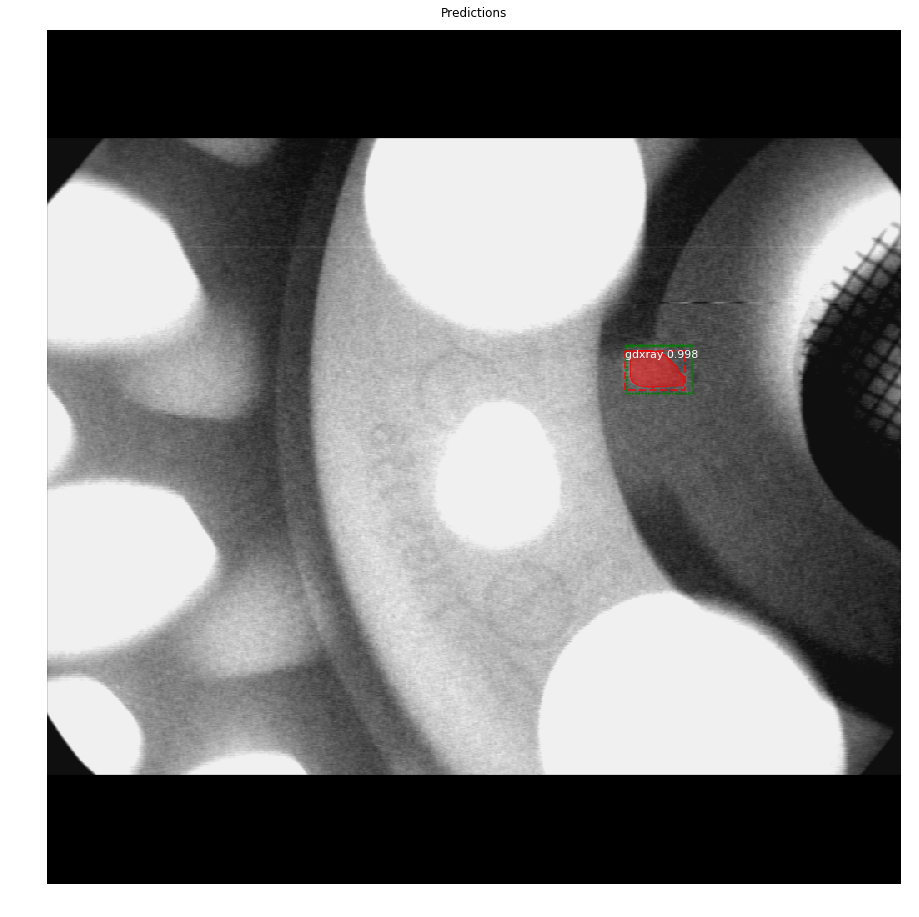

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
print('ROOT DIR', ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.insert(0, ROOT_DIR)

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
import mrcnn.data_generator as data_generator_lib
from mrcnn.model import log

from samples.gdxray import gdxray

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
# TODO: update this path
GDXRAY_WEIGHTS_PATH = "home/auro/keras-examples/Mask_RCNN/logs/gdxray20190414T1736/mask_rcnn_gdxray_0030.h5"

config = gdxray.GdxrayConfig()
GDXRAY_DIR = "/home/auro/via/n-test/"

# Override the training configurations with a few
# changes for inferencing.


class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


# Load validation dataset
dataset = gdxray.GdxrayDataset()
dataset.load_gdxray(GDXRAY_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(
    len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
print(MODEL_DIR)
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
print('Finished loading model')

# Set path to balloon weights file

# Load the last model you trained
weights_path = model.find_most_recent_checkpoint()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

# Run Detection

image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    data_generator_lib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
